# Smart Aid Distribution to the Poor

Having aid money isn't enough. Aid is effective only when the delivered to the right people. So, it is critical to be able to know who to deliver the aid to.  

In this kernel I do just that: I will analyze the data provided by the Inter-American Development Bank to build a model that can classify a Costa Rican household with respect to the experienced poverty level. 

To make the project more interesting I added monetary cost/benefit structure to reward models that are best at identifying households affected by povery as opposed to households that are not.

Here is the link to the data:
https://www.kaggle.com/c/costa-rican-household-poverty-prediction

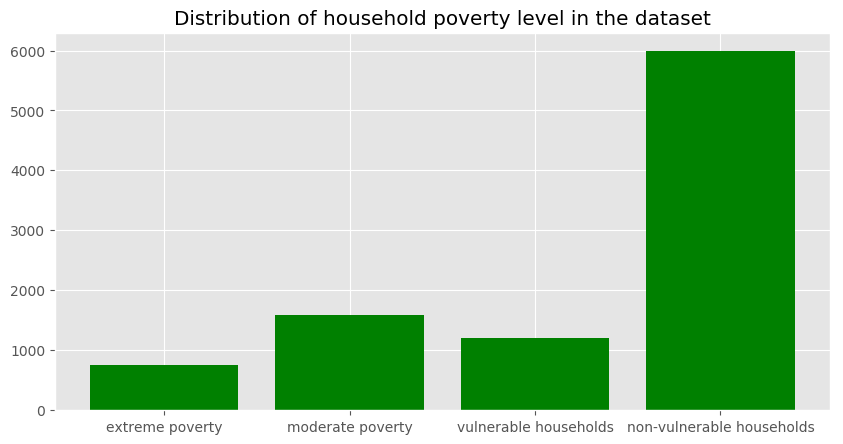

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
df = pd.read_csv("train.csv")
plot_d=df.groupby("Target")["Target"].count()
fig, axes = plt.subplots(figsize=(10,5), dpi=100)
plt.bar(['extreme poverty','moderate poverty',
         'vulnerable households',
         'non-vulnerable households'],height=plot_d,color='green')

plt.title('Distribution of household poverty level in the dataset')
plt.show()

From the graph we can see that:

- We are basically facing an imbalanced dataset 
- There are a total of 9,557 households in the dataset. 
- 5,996 or 63% are classified as non-voulnerable (category 4) meaning they do not need and likley will not need aid in the future.
- remaining 27% is divided into 3 categories ranging from extreme poverty to moderate poverty to being voulnerable (cat. 1 2 3).
- multiclass classification ML algorithm will be appropriate to use


I will build a model with an objective to predict which category a household falls into based on the household characteristics such as materials the house is made of or level of education of people in the household.

### Before going into machine learning it is important to think about what we want to achieve:

Looking at classification performance metrics is very useful from the perspective of a data scientist. Yet, what may matter the most to a bank that distributes the aid, is if the aid goes to the right place! F1 score may not mean much in such case. What would likely speak to a banker is the amount of money that was allocated to the right cause versus lost due to the implementation of the model.

As mentioned above, we certainly want to predict which category a household falls into. However, are all categories equally important?

I argue that, indeed, it is more important to have better classification for 1 and 2 categories versus 3 or 4 and here is why:

When implemented, the machine learning model will eventually predict the category label for each household. This is called predicted category. This category may or may not correspond to the actual category that the household should be classified as. Therefore, there is a total of four variants of prediction:

- True positive: Model's prediction corresponds to the actual houshold status I.e. Household is in extreme poverty and the model predicted it as such
- True negative: Reverse of the case above
- False positve: Model mislabeled a household that is not in extreme poverty as such
- False negative: Model did not detect a household to be in extreme poverty at all

Understanding different types of classification that a model can make, I then assigned different values to each type of classification:

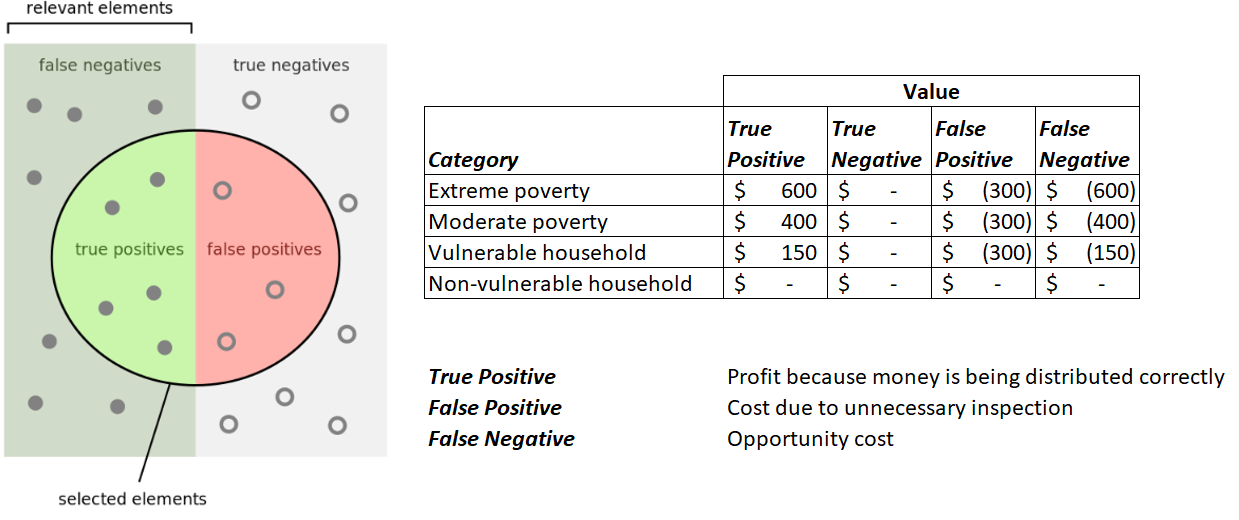

Next let's consider a simplified scenario:
- total of 28 households
- 9 in each of three categories
- category 1 corresponds to extreme poverty in table above
- category 2 corresponds to moderate poverty in table above
- category 3 corresponds to non-vulerable household in table above


Below I consider four variants of the scenario:
- A) Perfect prediction for each category: The model makes no mistakes and classifies each household correctly
- B) Model perfectly classifies the extremely poor households, does an ok job for moderately poor and randomly classifies category 3
- C) Inverse of variant B
- D) Model randomly predicts classification for each household

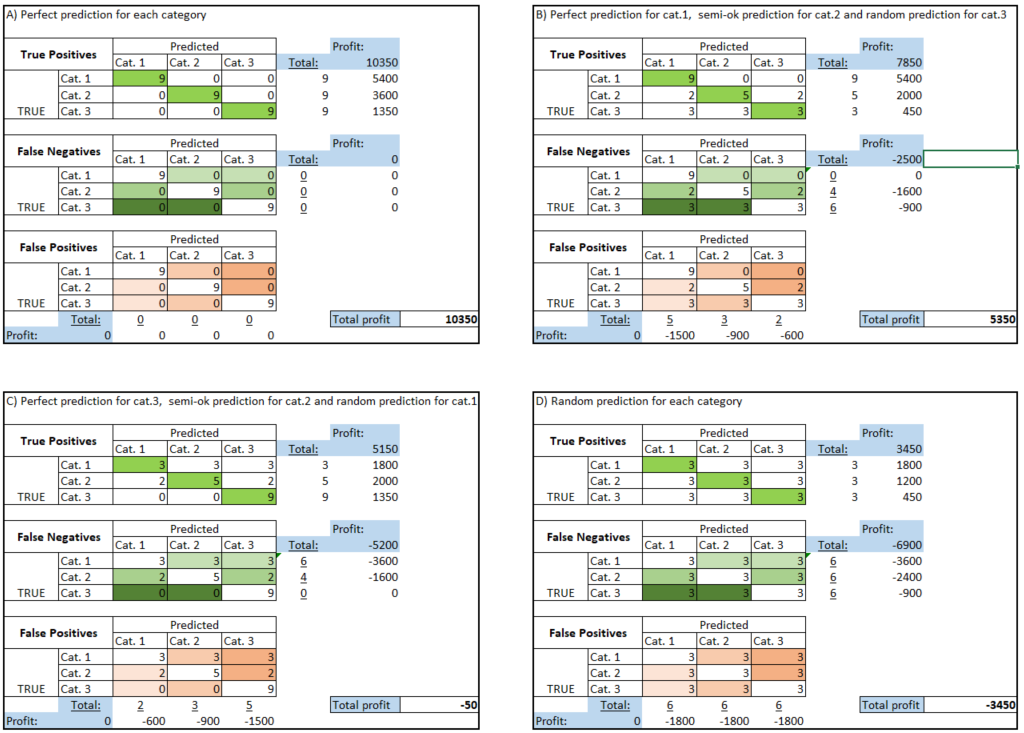

The graph below plots total profit for each scenario.

- Clearly prefect prediction (A) delivers the most profit.
- Next is case B, where the model performed better for categories A and B, which are also associated with higher cost/profit values
- Next is C, which is an inverse of case B. Since cat.3 was not as valuable (risky) as A or B, delivering better prediction there did not result in as much profit
- Last is case D where the model did nothing useful delivering random predictions for each case.


#### The important takeaway is that given the proposed value scenario, it is much more important for the model to make fewer errors in prediction of categories that are associated with higher value to the bank!

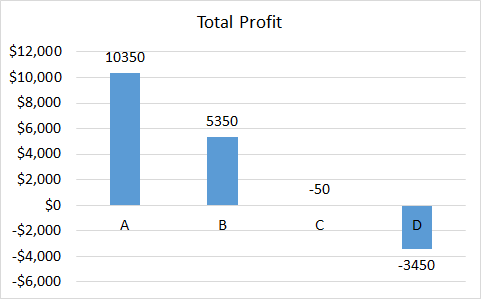

# Data Cleaning:

In [2]:
#import data
df = pd.read_csv("train.csv")
df.shape

(9557, 143)

In [3]:
numeric=[
'v2a1',
'rooms',
'v18q1',
'r4h1',
'r4h2',
'r4h3',
'r4m1',
'r4m2',
'r4m3',
'r4t1',
'r4t2',
'r4t3',
'tamhog',
'tamviv',
'escolari',
'rez_esc',
'hhsize',
'hogar_nin',
'hogar_adul',
'hogar_mayor',
'hogar_total', 
'dependency',
'edjefe',
'edjefa', 
'meaneduc',
'bedrooms', 
'overcrowding', 
'age',
'qmobilephone']

In [4]:
#derive categoric columns:
lista = df.columns.tolist()
new_lista= list()
for_removal = numeric+["Target",'idhogar','Id']
for item in lista:
    if item not in for_removal:
        new_lista.append(item)
categoric=new_lista[0:-9]
df[categoric].dtypes.unique()

array([dtype('int64')], dtype=object)

In [5]:
#Check for null values
null = df[numeric].isnull().sum()
null[null!=0]

v2a1        6860
v18q1       7342
rez_esc     7928
meaneduc       5
dtype: int64

In [6]:
df['dependency'].dtypes

dtype('O')

In [7]:
#remove dependency and check for dtypes in the dataset
numeric.remove("dependency")
df[numeric].dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('O')], dtype=object)

In [8]:
#again check for null values:
null =df[numeric].isnull().sum()
null[null!=0]

v2a1        6860
v18q1       7342
rez_esc     7928
meaneduc       5
dtype: int64

In [11]:
#check for null values in the categoric variables
np.sum(df[categoric].isnull().sum())

0

In [12]:
# Check for numeric variables that contain objects
df[numeric].dtypes

v2a1            float64
rooms             int64
v18q1           float64
r4h1              int64
r4h2              int64
r4h3              int64
r4m1              int64
r4m2              int64
r4m3              int64
r4t1              int64
r4t2              int64
r4t3              int64
tamhog            int64
tamviv            int64
escolari          int64
rez_esc         float64
hhsize            int64
hogar_nin         int64
hogar_adul        int64
hogar_mayor       int64
hogar_total       int64
edjefe           object
edjefa           object
meaneduc        float64
bedrooms          int64
overcrowding    float64
age               int64
qmobilephone      int64
dtype: object

In [13]:
# remove non-numeric values from the numeric variables
df["edjefa"]=df["edjefa"].apply(lambda x: '0' if (x=="no" or x=="yes") else x).apply(lambda x: int(x))
df["edjefe"]=df["edjefe"].apply(lambda x: '0' if (x=="no" or x=="yes") else x).apply(lambda x: int(x))
df.loc[df["meaneduc"].isnull(),"meaneduc"] =df["meaneduc"].median()

In [14]:
#check again for objects:
df[numeric].dtypes

v2a1            float64
rooms             int64
v18q1           float64
r4h1              int64
r4h2              int64
r4h3              int64
r4m1              int64
r4m2              int64
r4m3              int64
r4t1              int64
r4t2              int64
r4t3              int64
tamhog            int64
tamviv            int64
escolari          int64
rez_esc         float64
hhsize            int64
hogar_nin         int64
hogar_adul        int64
hogar_mayor       int64
hogar_total       int64
edjefe            int64
edjefa            int64
meaneduc        float64
bedrooms          int64
overcrowding    float64
age               int64
qmobilephone      int64
dtype: object

In [15]:
null=df[numeric].isnull().sum()
null[null!=0]

v2a1       6860
v18q1      7342
rez_esc    7928
dtype: int64

In [16]:
#further clean the dataset:
df.loc[df["v18q1"].isnull(),"v18q1"]=0
df.loc[df["rez_esc"].isnull(),"rez_esc"]=0

null=df[numeric].isnull().sum()
null[null!=0]

v2a1    6860
dtype: int64

In [17]:
#drop v2a1 since too many values are missing and combine the data into final form
data=df[numeric[1:]+categoric+["Target"]].copy()

# Machine Learning:

In [18]:
#import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split

#Import multiclass classification models:
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from xgboost.sklearn import XGBClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [19]:
data=data.copy().iloc[:,1:]
variables = data.iloc[:,:-1].copy()
target = data.iloc[:,-1:].copy()
print(variables.shape)
print(target.shape)

(9557, 128)
(9557, 1)


### Split data into train and test subsets:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(variables,target, test_size=0.30, random_state=1)

In [21]:
def value_function(actual, predicted,c1_tp=600,c1_fp=-300,c1_fn=-600,c2_tp=400,
          c2_fp=-300,c2_fn=-400,c3_tp=150,c3_fp=-300,c3_fn=-150,c4_tp=0,c4_fp=0,c4_fn=0,p=1):
    '''Calculates the value of the model based on relative value of itentifying
    true positive, false positive and false negative for each category.'''
    
    #create a confusion matrix
    m=confusion_matrix(actual, predicted).tolist()
    
    #extract value for category 1:
    tp =m[0][0]
    fp = m[1][0]+m[2][0]+m[3][0]
    fn = np.sum(m[0][1:])
    value_c1=c1_tp*tp+c1_fp*fp+c1_fn*fn
    #extract value for category 2:
    tp =m[1][1]
    fp = m[0][1]+m[2][1]+m[3][1]
    fn = m[1][0]+  np.sum(m[1][2:])
    value_c2=c2_tp*tp+c2_fp*fp+c2_fn*fn
   
    #extract value for category 3:
    tp =m[2][2]
    fp = m[0][2]+m[1][2]+m[3][2]
    fn = m[2][3]+  np.sum(m[2][0:2])
    value_c3=c3_tp*tp+c3_fp*fp+c3_fn*fn

    #extract value for category 4:
    tp =m[3][3]
    fp = m[0][3]+m[1][3]+m[2][3]
    fn = np.sum(m[3][0:3])
    value_c4=c4_tp*tp+c4_fp*fp+c4_fn*fn

    total_value = value_c1+value_c2+value_c3+value_c4
    p=p
    if p==1:
        print("\nConfusion Matrix: x-predicted, y-true")
        print(confusion_matrix(actual, predicted))
        print("\nModel value: $"+str(int(total_value)))
        print("F1 score: "+str(round(f1_score(actual, predicted, average='micro'),3)))
    return total_value

def check_initial(model,X_train=X_train,y_train=y_train,X_test=X_test):
    '''Checks model for basic performance'''
    mod = model
    mod.fit(X_train,y_train.values.ravel())
    predicted = mod.predict(X_test)
    mod_value = value_function(y_test,predicted)
    values_initial[str(mod)[0:15]]=mod_value
    print(mod_value)

def check(model,X_train=X_train,y_train=y_train,X_test=X_test):
    '''Checks model for basic performance'''
    mod = model
    mod.fit(X_train,y_train.values.ravel())
    predicted = mod.predict(X_test)
    mod_value = value_function(y_test,predicted)
    print(mod_value)

models = [LogisticRegressionCV(multi_class='multinomial'),
BernoulliNB(),
DecisionTreeClassifier(),
ExtraTreeClassifier(),
ExtraTreesClassifier(),
GaussianNB(),
KNeighborsClassifier(),
LabelPropagation(),
LabelSpreading(),
LinearDiscriminantAnalysis(),
MLPClassifier(),
NearestCentroid(),
QuadraticDiscriminantAnalysis(),
RandomForestClassifier(),
RidgeClassifier(),
RidgeClassifierCV(),
LinearSVC(multi_class='crammer_singer'),
XGBClassifier()]
         

In [22]:
#create a dictionary to store the results:
values_initial =dict()

for item in models:
    print("\n\n"+str(item))
    check_initial(item)
    
vals, keys =[],[]
for key, value in values_initial.items():
    keys.append(key)
    vals.append(value)
mods=pd.concat([pd.Series(keys),pd.Series(vals)], axis=1).sort_values(by=1, ascending = True)



LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

Confusion Matrix: x-predicted, y-true
[[  49   78    5   76]
 [  37  192   26  234]
 [  14   67   39  245]
 [   9   83   25 1689]]

Model value: $-254250
F1 score: 0.687
-254250


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Confusion Matrix: x-predicted, y-true
[[  77   59   19   53]
 [ 109  181   54  145]
 [  49  108   42  166]
 [  76  210  101 1419]]

Model value: $-360850
F1 score: 0.599
-360850


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\semi_supervised\label_propagation.py:201: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer



Confusion Matrix: x-predicted, y-true
[[ 101   31   18   58]
 [  95  191   39  164]
 [  61   47  121  136]
 [ 202  108  117 1379]]

Model value: $-280250
F1 score: 0.625
-280250


LabelSpreading(alpha=0.2, gamma=20, kernel='rbf', max_iter=30, n_jobs=1,
        n_neighbors=7, tol=0.001)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\semi_supervised\label_propagation.py:201: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")



Confusion Matrix: x-predicted, y-true
[[ 101   32   18   57]
 [  94  191   40  164]
 [  60   46  121  138]
 [ 202  108  117 1379]]

Model value: $-279950
F1 score: 0.625
-279950


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

Confusion Matrix: x-predicted, y-true
[[  45   73    9   81]
 [  63  160   37  229]
 [  21   55   47  242]
 [  25   80   32 1669]]

Model value: $-297550
F1 score: 0.67
-297550


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Confusion Matrix: x-predicted, y-true
[[  88   44   18   58]
 [  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[[ 191    6   11    0]
 [ 431   20   38    0]
 [ 319    1   45    0]
 [1560    8  179   59]]

Model value: $-882350
F1 score: 0.11
-882350


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Confusion Matrix: x-predicted, y-true
[[ 156   25    3   24]
 [  10  394   11   74]
 [   7   25  246   87]
 [   3   21   17 1765]]

Model value: $164450
F1 score: 0.893
164450


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)

Confusion Matrix: x-predicted, y-true
[[  24   74    2  108]
 [  22  154   14  299]
 [

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


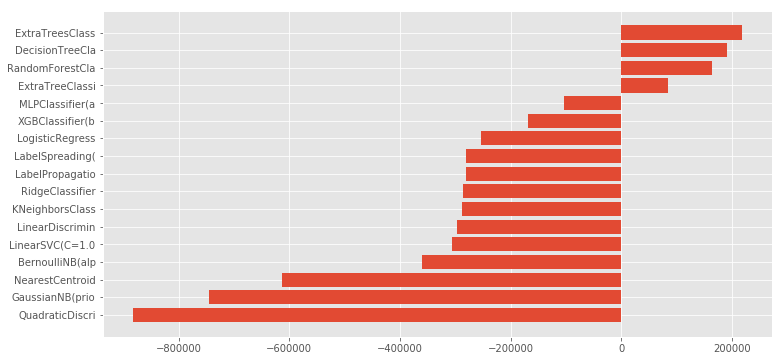

In [23]:
plt.figure(figsize=(12,6))
plt.barh(range(len(mods)),mods[1])
plt.yticks(range(len(mods)), list(mods[0]))
plt.show()

## Experimenting with ExtraTreesClassifier

Extra Trees Classifier delivered the best results so far. Let's further experiment with this model.

### Base Case Check:

In [24]:
check(ExtraTreesClassifier(random_state=1))


Confusion Matrix: x-predicted, y-true
[[ 172   16    0   20]
 [   8  424    9   48]
 [   2   21  275   67]
 [   3    9    9 1785]]

Model value: $229850
F1 score: 0.926
229850


### Since the dataset is imbalanced experiment with class weights

In [25]:
from sklearn.utils import class_weight
y=target.copy()
x=variables.copy()
#determine class weights based on entire dataset:
class_weight = class_weight.compute_class_weight('balanced',np.unique(y),y.values.ravel())
#create a dictionary with the weights:
cl_weights =dict()
for item1, item2 in zip(class_weight, np.unique(y)):
    cl_weights[item2]=item1
check(ExtraTreesClassifier(random_state=1, class_weight=cl_weights))


Confusion Matrix: x-predicted, y-true
[[ 174   16    0   18]
 [  12  421   10   46]
 [   2   28  282   53]
 [   3   12   11 1780]]

Model value: $226850
F1 score: 0.926
226850


Conclusion: rebalancing the dataset with class_weight tool did not yield better performing model

### Oversample the Dataset

In [26]:
data = pd.concat([X_train,y_train], axis=1).copy()

c1=len(data[data["Target"]==1])
c2=len(data[data["Target"]==2])
c3=len(data[data["Target"]==3])
c4=len(data[data["Target"]==4])

c1_new = data[data["Target"]==1].sample(frac=c4/c1, replace=True,random_state=1).copy()
c2_new = data[data["Target"]==2].sample(frac=c4/c2, replace=True,random_state=1).copy()
c3_new = data[data["Target"]==3].sample(frac=c4/c3, replace=True,random_state=1).copy()
c4=data[data["Target"]==4].copy()

data_new = pd.concat([c1_new,c2_new,c3_new,c4]).sample(frac=1,random_state=1)

variables_new = data_new.iloc[:,:-1].copy()
target_new = data_new.iloc[:,-1:].copy()

check(ExtraTreesClassifier(random_state=1),variables_new,target_new,X_test)


Confusion Matrix: x-predicted, y-true
[[ 168   18    0   22]
 [  13  428   11   37]
 [   2   16  288   59]
 [   6   10    9 1781]]

Model value: $229750
F1 score: 0.929
229750


Oversampling the dataset did not yield a better performin model.

# Oversampling + Ensemble cross validation

In [27]:
data = data_new.copy()

In [28]:
data.loc[data.index[0:3352],"fold"] = 1
data.loc[data.index[3352:6704],"fold"] = 2
data.loc[data.index[6704:10056],"fold"] = 3
data.loc[data.index[10056:13408],"fold"] = 4
data.loc[data.index[13408:],"fold"] = 5

In [29]:
fold_ids = [1,2,3,4,5]

def train_and_validate(df, folds,xtest): 
    pred=list()

    for fold in folds:
        train = df.loc[(df["fold"] != fold), :]
        test  = df.loc[(df["fold"] == fold), :]
    
        rf=ExtraTreesClassifier(random_state=1)

        rf.fit(train.iloc[:,:-2], train.iloc[:,129])
        predictions_on_test = rf.predict_proba(xtest)
        
        pred.append(predictions_on_test.tolist())
    
    cl_1=list()
    cl_2=list()
    cl_3=list()
    cl_4=list()   
     
    
    for i,j,k,l,m in zip(pred[0],pred[1],pred[2],pred[3],pred[4]):    
        class_1_av= (i[0]+j[0]+k[0]+l[0]+m[0])/5
        cl_1.append(class_1_av)
        class_2_av= (i[1]+j[1]+k[1]+l[1]+m[1])/5
        cl_2.append(class_2_av)
        class_3_av= (i[2]+j[2]+k[2]+l[2]+m[2])/5
        cl_3.append(class_3_av)
        class_4_av= (i[3]+j[3]+k[3]+l[3]+m[3])/5
        cl_4.append(class_4_av)
        
    c1=pd.DataFrame(cl_1,columns =['1'])
    c2=pd.DataFrame(cl_2,columns =['2']) 
    c3=pd.DataFrame(cl_3,columns =['3']) 
    c4=pd.DataFrame(cl_4,columns =['4'])
    result = pd.concat([c1, c2,c3,c4], axis=1)

    return result
    
pred = train_and_validate(data, fold_ids,X_test)

def class_selection(row):
        if row.iloc[0]> 0.3:
            return 1
        elif row.iloc[1]>0.5:
            return 2
        elif row.iloc[2]>0.3:
            return 3
        else:
            return 4
pred["result"]=pred.apply(lambda row: class_selection(row), axis=1)

print("Performance on test dataset:")
value_function(y_test,pred["result"])

Performance on test dataset:

Confusion Matrix: x-predicted, y-true
[[  3   0  50 155]
 [ 16   1 144 328]
 [  9   0  97 259]
 [336  39 507 924]]

Model value: $-671950
F1 score: 0.357


-671950

This technique as well did not improve the prediction performance.

Now let's go back to the original RandomTreesClassifier to optimize the hyperparameters:

### Hyperparameter optimization for ExtraTreesClassifier

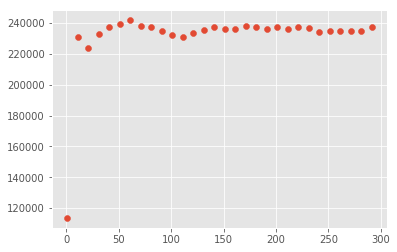

In [30]:
def check_special(model,X_train=X_train,y_train=y_train,X_test=X_test):
    '''Checks model for basic performance and returns monetary value'''
    mod = model
    mod.fit(X_train,y_train.values.ravel())
    predicted = mod.predict(X_test)
    mod_value = value_function(y_test,predicted,p=0)
    return mod_value

parameter = np.arange(1,300,10)
result=[]
for item in parameter:
    res=check_special(ExtraTreesClassifier(random_state=1, n_estimators=item))
    result.append(res)
plt.scatter(parameter, result)
plt.show()

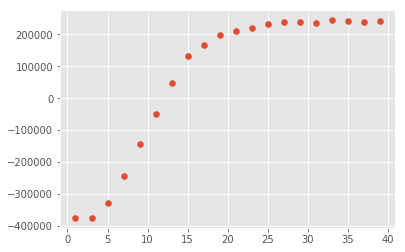

In [31]:
parameter = np.arange(1,40,2)
result=[]
for item in parameter:
    res=check_special(ExtraTreesClassifier(random_state=1, max_depth = item, n_estimators=50))
    result.append(res)
plt.scatter(parameter, result)
plt.show() 

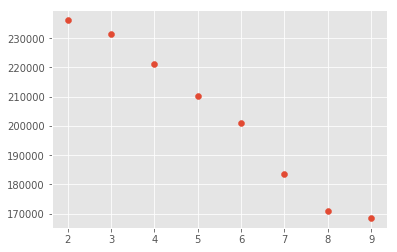

In [32]:
parameter = np.arange(2,10,1)
result=[]
for item in parameter:
    res=check_special(ExtraTreesClassifier(random_state=1, min_samples_split=item,max_depth = 30, n_estimators=50))
    result.append(res)
plt.scatter(parameter, result)
plt.show()

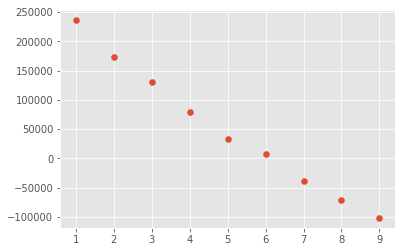

In [33]:
parameter = np.arange(1,10,1)
result=[]
for item in parameter:
    res=check_special(ExtraTreesClassifier(random_state=1, min_samples_leaf=item,
                                           min_samples_split=2,max_depth = 30, n_estimators=50))
    result.append(res)
plt.scatter(parameter, result)
plt.show()

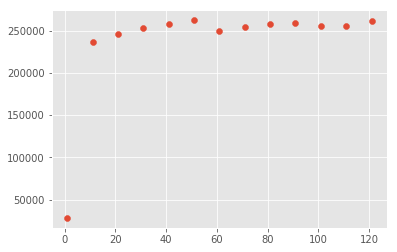

In [34]:
parameter = np.arange(1,129,10)
result=[]
for item in parameter:
    res=check_special(ExtraTreesClassifier(random_state=1, max_features = item, min_samples_leaf=1,
                                           min_samples_split=2,max_depth = 30, n_estimators=50))
    result.append(res)
plt.scatter(parameter, result)
plt.show()

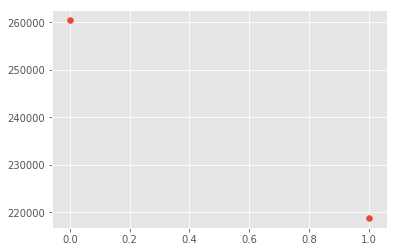

In [35]:
parameter = [True, False]
result=[]
for item in parameter:
    res=check_special(ExtraTreesClassifier(random_state=1, bootstrap=item, max_features = 120, min_samples_leaf=1,
                                           min_samples_split=2,max_depth = 30, n_estimators=50))
    result.append(res)
plt.scatter(parameter, result)
plt.show()

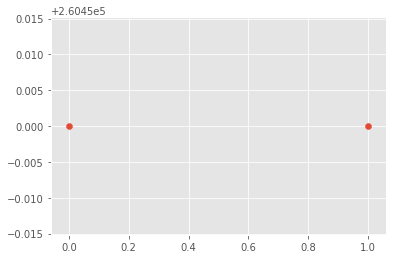

[260450, 260450]


In [36]:
parameter = [True, False]
result=[]
for item in parameter:
    res=check_special(ExtraTreesClassifier(random_state=1, warm_start = item,bootstrap=False, max_features = 120, min_samples_leaf=1,
                                           min_samples_split=2,max_depth = 30, n_estimators=50))
    result.append(res)
plt.scatter(parameter, result)
plt.show()
print(result)

#### Model with optimized hyperparameters:

In [37]:
model = ExtraTreesClassifier(random_state=1, warm_start = False,bootstrap=False, max_features = 120, min_samples_leaf=1,
                                           min_samples_split=2,max_depth = 30, n_estimators=50)
check(model)


Confusion Matrix: x-predicted, y-true
[[ 180   18    0   10]
 [  11  442    8   28]
 [   1   17  301   46]
 [   3   11   12 1780]]

Model value: $260450
F1 score: 0.942
260450


In [38]:
#derivation of important features:
mod = ExtraTreesClassifier(random_state=1, warm_start = False,bootstrap=False, max_features = 120, min_samples_leaf=1,
                                           min_samples_split=2,max_depth = 30, n_estimators=50)
mod.fit(X_train,y_train.values.ravel())
predicted = mod.predict(X_test)
mod_value = value_function(y_test,predicted)

feature_importances = pd.DataFrame(mod.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

feature_importances.iloc[:10,:]


Confusion Matrix: x-predicted, y-true
[[ 180   18    0   10]
 [  11  442    8   28]
 [   1   17  301   46]
 [   3   11   12 1780]]

Model value: $260450
F1 score: 0.942


,importance
meaneduc,0.060881
hogar_nin,0.045707
cielorazo,0.044272
qmobilephone,0.027261
overcrowding,0.027251
r4t1,0.026191
edjefe,0.025460
hogar_adul,0.020831
bedrooms,0.019047
r4h2,0.017738


# Feature Engineering: Mean Encoding

In order to further improve the performance of the optimized model I will apply the technique called Mean Encoding. For each variable I will derive a new parameter that is based on the average relationship of that variable to the target variable. 

The optimization will done using the train dataset so that the evaluation of the model performance will not be compromized by the target variable from the test dataset.

In [39]:
#import data
data = pd.read_csv("final_train.csv")
data=data.copy().iloc[:,1:]
variables = data.iloc[:,:-1].copy() #Just variables columns
target = data.iloc[:,-1:].copy() #Just target column
X_train, X_test, y_train, y_test = train_test_split(variables,target, test_size=0.30, random_state=1)
train = pd.concat([X_train,y_train], axis=1) #in this step I combine train variables and target to a single df

In [40]:
dic={} #next an empty dictionary is created to store mean weights
#with the following loop for each variable I am deriving a dictionary of mean weights
#associated with the relationship of the target variable to each unique value in the column
for variable in variables.columns.tolist():
    means = {}
    for x in train[variable].unique():
        z = train[train[variable]== x]["Target"].mean()
        means[x]=z
    dic[variable]=means


def feature_mean(x,dic): 
    '''The function applies mean weights to each value in dataframe'''
    for key, value in dic.items():
        if x == key:
            return value

#In the following lines I am engineering new features by applying the created function
X_test_new = X_test.copy()
X_train_new = X_train.copy()
for key, value in dic.items(): 
    X_test_new[key+"_feature_mean"] = X_test[key].apply(lambda x: feature_mean(x,dic[key]))
    
for key, value in dic.items(): 
    X_train_new[key+"_feature_mean"] = X_train[key].apply(lambda x: feature_mean(x,dic[key]))
    
X_test_new = X_test_new.fillna(method='ffill') #fill in missing values

In [41]:
#run the model on feature engineered dataset
mod = ExtraTreesClassifier(random_state=1, warm_start = False,bootstrap=False, max_features = 120, min_samples_leaf=1,
                                           min_samples_split=2,max_depth = 30, n_estimators=50)
mod.fit(X_train_new,y_train.values.ravel())
predicted = mod.predict(X_test_new)
value_function(y_test,predicted)


Confusion Matrix: x-predicted, y-true
[[ 179   20    0    9]
 [  13  439    7   30]
 [   1   15  306   43]
 [   6    8    6 1786]]

Model value: $259850
F1 score: 0.945


259850

The mean encoding further improved the performance of the model raising the F1 score from 0.942 to 0.945. However, the improvement reduced the value slightly ($600) since the improvement went towards better prediction of categories associated with less poverty. For that reason it is important to consider the implications of model performance on the value to the user.

# Conclusions

The best model to predict the level of poverty for households in the provided dataset was the RandomTreesClassifier with mean encoded features (On F1 score basis).

Finally, let's compare the performance of the generated model to a case in which outcomes for each household are randomly selected based on know distribution of categories:

If we were to randomly predict the category each sample in the sample of 2,686 households would be classified as, we would likely end up with such confusion matrix. This is a likely scenario of a randomly predicted outcome based on the average distribution of categories (1: 7.25%, 2: 17.05%, 3: 12.73%, 4: 62.97%).

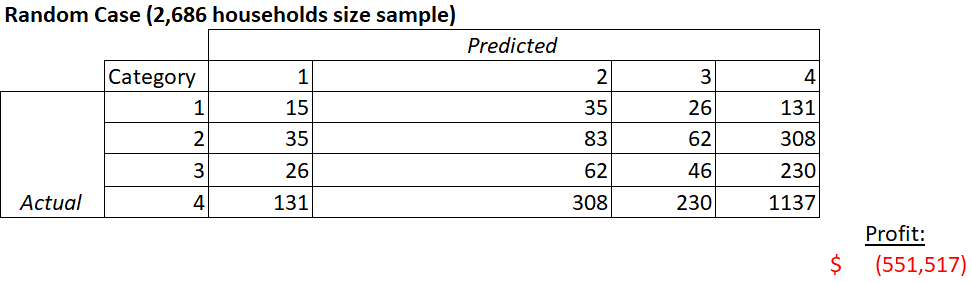

As we can see, our best guessing would on average result in  a loss of over half a million dollars according to our value scenario.

#### On the other had the best machine learning model developed in this project had a potential of delivering $260,450 value!

It is also worth pointing out that some of the models initially tested for performance did worse than random guessing, delivering much greater losses.

#### Lastly, a few words about the top 10 important parameters:

- 1) meaneduc:	average years of education for adults (18+)
- 2) hogar_nin:	Number of children 0 to 19 in household
- 3) cielorazo:	if the house has ceiling
- 4) qmobilephone:	# of mobile phones
- 5) overcrowding:	# persons per room
- 6) r4t1:	persons younger than 12 years of age
- 7) edjefe:	years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- 8) hogar_adul:	Number of adults in household
- 9) bedrooms:	number of bedrooms
- 10) r4h2: Males 12 years of age and older

In [42]:
data.groupby("Target")[feature_importances.iloc[:10,:].index].mean()

,meaneduc,hogar_nin,cielorazo,qmobilephone,overcrowding,r4t1,edjefe,hogar_adul,bedrooms,r4h2
Target,,,,,,,,,,
1,6.869205,2.308609,0.421192,2.096689,2.043996,1.596026,2.343046,2.147020,2.393377,1.160265
2,7.300397,2.020664,0.474014,2.463369,1.952244,1.188478,3.412649,2.341265,2.529743,1.474640
3,7.615495,1.672457,0.559140,2.761787,1.758905,0.847808,4.406121,2.600496,2.686518,1.692308
4,10.368978,1.075884,0.787692,3.020180,1.426810,0.562875,6.010841,2.713809,2.850400,1.605070


In summary better education, higher house quality and size as well as lower occupancy density, fewer children and ownership of material goods are indicators of more affluence and lower likelihood of being a poor household.